Using TensorFlow backend.


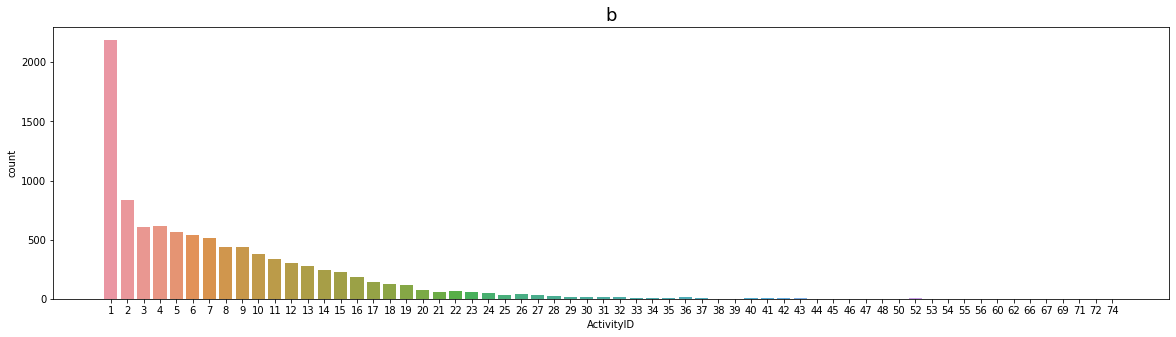

In [4]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import seaborn as sns
from t2e_utils import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
palette=sns.color_palette("RdBu_r", 50)
import pickle
import random
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import wtte.wtte as wtte

from keras.models import Sequential, load_model,Model
from keras.initializers import glorot_normal
from keras.layers import Dense,LSTM,GRU,Activation,Masking,BatchNormalization,Lambda,Input
from keras import backend as K
from keras import callbacks
from keras.optimizers import RMSprop,adam,Nadam
from keras.callbacks import History, EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
import os
plt.style.use('seaborn-muted')
# # np.random.seed(2)
# # pd.set_option("display.max_rows",1000)
%matplotlib inline
%load_ext autoreload
%autoreload 2
import h5py


path = '../Tax_paper/data/'
b = os.path.join(path,'bpi_12_w.csv')
b = pd.read_csv(b)

df_dict = {
    'a': None,
    'b': b,
    'c': None,
    'd':None
}
range_dict = {
    'a': range(2,8,1),
    'b': range(2,22,2),
    'c': range(2,12,2),
    'd': range(2,22,2)
}

for key, dataset in df_dict.items():
    if key == 'b':
        plt.figure(figsize=(20,5))
        sns.countplot(dataset.groupby(["CaseID"]).agg({"ActivityID":'count'})["ActivityID"])
        plt.title(key,fontsize=18)
        plt.plot()

In [ ]:
# baseline = {}
# for dataset in ['b']:
#     tmp = df_dict[dataset].groupby(["Prefix length"]).apply(lambda x:mean_absolute_error(x['Ground truth times'], x['Predicted times'])/86400).to_dict()
#     tmp = {k:v for k,v in tmp.items() if k in list(range_dict[dataset])}
#     baseline[dataset] = list(tmp.values())
# pickle.dump(baseline, open("baseline.pkl","wb"))

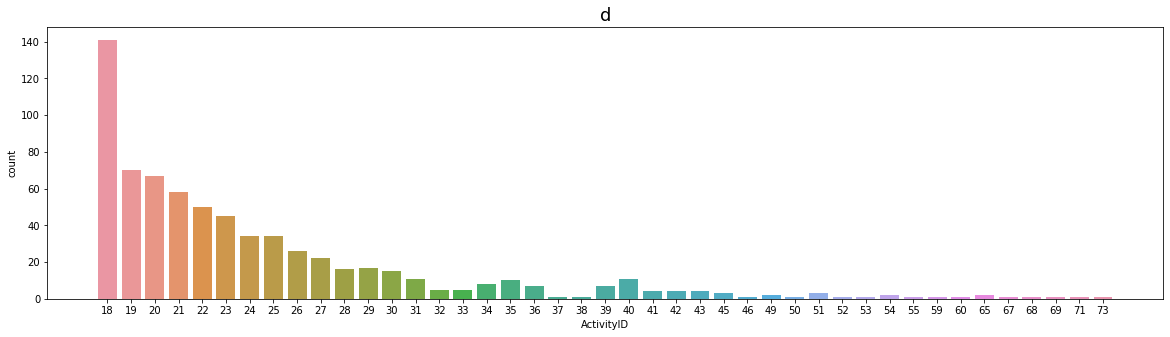

In [9]:
suffix = 18

dataset_preprocessed     = preprocess(b, censored = False, min_length = suffix, cen_prc = None)
# dataset_preprocessed = preprocess(b, censored = True,  min_length = suffix, cen_prc = 0.4)

plt.figure(figsize=(20,5));
sns.countplot(dataset_preprocessed_cen.groupby(["CaseID"]).agg({"ActivityID":'count'})["ActivityID"]);
plt.title(key,fontsize=18);
plt.plot();

In [11]:
res = 's'
X_train, X_test, X_val, y_train, y_test, y_val = smart_split(dataset_preprocessed, 
                                                             train_perc = 0.67,
                                                             val_perc = 0.33,
                                                             suffix = suffix,
                                                             resolution=res,
                                                             scaling = False)
print("\n")
print("Training   shape:",X_train.shape, y_train.shape)
print("Validation shape:",X_val.shape, y_val.shape)
print("Testing    shape:",X_test.shape, y_test.shape)

Total above suffix: 697
Total Observed: 697
Total above suffix (observed): 697
Training data Observed: 313
Training data Censored: 0
Training data combined: 313


Training   shape: (313, 18, 8) (313, 2)
Validation shape: (153, 18, 8) (153, 2)
Testing    shape: (231, 18, 8) (231, 2)


In [12]:
print(X_train[0,0,-3:-1])
print(y_train[0,:])

[0. 0.]
[1.656583e+06 1.000000e+00]


SUFFIX = 18:

[ 0. 18.]

[660374.      0.]

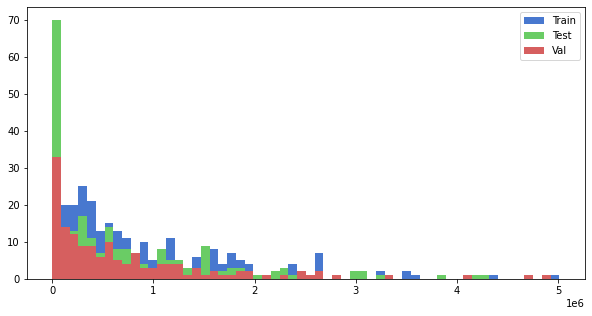

In [13]:
if res == 'd':
    bins = np.arange(0,y_train.max()+1, 1)
elif res == 'h':
    bins = np.arange(0,y_train.max()+24, 24)
elif res == 's':
    bins = np.arange(0,y_train.max()+86400, 86400)
    
plt.figure(figsize=(10,5))
plt.hist(y_train[:,0], bins = bins,label="Train");

plt.hist(y_test[:,0], bins = bins, label="Test");
plt.hist(y_val[:,0], bins = bins,label="Val");
plt.legend()
plt.show()

## Model

In [34]:
test_out_path = "testing_output/"

def train_notebook(X_train, y_train, X_val, y_val):
    tte_mean_train = np.nanmean(y_train[:,0].astype('float'))
    mean_u = np.nanmean(y_train[:,1].astype('float'))
    init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
    init_alpha = init_alpha/mean_u
    history = History()
    cri = 'val_loss'
    csv_logger = CSVLogger(test_out_path + 'training.log', separator=',', append=False)
    es = EarlyStopping(monitor=cri, mode='min', verbose=True, patience=100, restore_best_weights=True)
    mc = ModelCheckpoint(test_out_path + 'best_model.h5', monitor=cri, mode='min', verbose=True, save_best_only=True, save_weights_only=True)
    lr_reducer = ReduceLROnPlateau(monitor=cri, factor=0.5, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
    n_features = X_train.shape[-1]

    main_input = Input(shape=(None, n_features), name='main_input')
#     mask_input = Masking(mask_value=0, name='mask_input')(main_input)
    l1 = GRU(64, activation='tanh', kernel_initializer=glorot_normal(), recurrent_dropout=0.2,return_sequences=True)(main_input)
    b0 = BatchNormalization()(l1)
    l11 = GRU(16, activation='tanh',kernel_initializer=glorot_normal(), recurrent_dropout=0.2,return_sequences=False)(b0)
    b1 = BatchNormalization()(l11)
    l2 = Dense(2, kernel_initializer=glorot_normal(), name='Dense')(b1)
    b2 = BatchNormalization()(l2)
    output = Lambda(wtte.output_lambda, arguments={"init_alpha":init_alpha,"max_beta_value":100, "scalefactor":0.5})(b2)
    loss = wtte.loss(kind='continuous',reduce_loss=False).loss_function
    model = Model(inputs=[main_input], outputs=[output])
    model.compile(loss=loss, optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3))

    mg_train = batch_gen(X_train, y_train)
    mg_val = batch_gen(X_val, y_val)
    model.load_weights(test_out_path + "initialization.h5")

    model.fit_generator(mg_train, 
                        epochs=500,
                        steps_per_epoch = ceil(len(X_train) / batch_size),
                        validation_data=(mg_val),
                        validation_steps= ceil(len(X_val) / batch_size),
                        verbose=True,
                        callbacks=[history,mc,es,csv_logger],
                        shuffle=False
                    
                   )
    return model
model = train_notebook(X_train, y_train, X_val, y_val)

Epoch 1/500
3/3 [==============================] - 1s 430ms/step - loss: 2.3013 - val_loss: 2.1431

Epoch 00001: val_loss improved from inf to 2.14311, saving model to testing_output/best_model.h5
Epoch 2/500
3/3 [==============================] - 0s 27ms/step - loss: 2.2335 - val_loss: 2.1400

Epoch 00002: val_loss improved from 2.14311 to 2.13995, saving model to testing_output/best_model.h5
Epoch 3/500
3/3 [==============================] - 0s 22ms/step - loss: 2.2246 - val_loss: 2.0971

Epoch 00003: val_loss improved from 2.13995 to 2.09714, saving model to testing_output/best_model.h5
Epoch 4/500
3/3 [==============================] - 0s 24ms/step - loss: 2.2903 - val_loss: 2.1678

Epoch 00004: val_loss did not improve from 2.09714
Epoch 5/500
3/3 [==============================] - 0s 23ms/step - loss: 2.2143 - val_loss: 2.2091

Epoch 00005: val_loss did not improve from 2.09714
Epoch 6/500
3/3 [==============================] - 0s 23ms/step - loss: 2.1514 - val_loss: 2.2215

Epoc

3/3 [==============================] - 0s 40ms/step - loss: 1.8622 - val_loss: 2.2811

Epoch 00054: val_loss did not improve from 2.09714
Epoch 55/500
3/3 [==============================] - 0s 32ms/step - loss: 1.8821 - val_loss: 2.2915

Epoch 00055: val_loss did not improve from 2.09714
Epoch 56/500
3/3 [==============================] - 0s 33ms/step - loss: 1.8874 - val_loss: 2.3047

Epoch 00056: val_loss did not improve from 2.09714
Epoch 57/500
3/3 [==============================] - 0s 31ms/step - loss: 1.8515 - val_loss: 2.2983

Epoch 00057: val_loss did not improve from 2.09714
Epoch 58/500
3/3 [==============================] - 0s 31ms/step - loss: 1.8565 - val_loss: 2.2925

Epoch 00058: val_loss did not improve from 2.09714
Epoch 59/500
3/3 [==============================] - 0s 31ms/step - loss: 1.8869 - val_loss: 2.2817

Epoch 00059: val_loss did not improve from 2.09714
Epoch 60/500
3/3 [==============================] - 0s 31ms/step - loss: 1.8402 - val_loss: 2.2744

Epoch 0

In [27]:
# model.save_weights(test_out_path + "initialization.h5")

36.797 %
8.303741777456482


0.000000         145
10535.723302       1
14358.210839       1
43768.222318       1
10853.056492       1
                ... 
65705.051264       1
106569.804600      1
72200.944059       1
12968.713708       1
99181.827787       1
Name: predicted_mode, Length: 87, dtype: int64

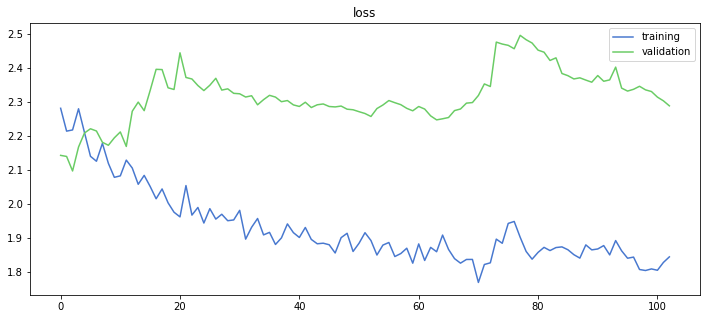

In [35]:
model.load_weights(test_out_path + 'best_model.h5')
history = pd.read_csv(test_out_path + 'training.log', sep=',', engine='python')

test_result_df, mae, accuracy = evaluating(X_test,y_test, model, resolution = res)
print(accuracy, "%")
print(mae)

plt.figure(figsize = (12,5));
plt.plot(history['loss'], label='training');
plt.plot(history['val_loss'],label='validation');
plt.title('loss');
plt.legend();
test_result_df["predicted_mode"].value_counts()

###############################################################################################################################

No handles with labels found to put in legend.


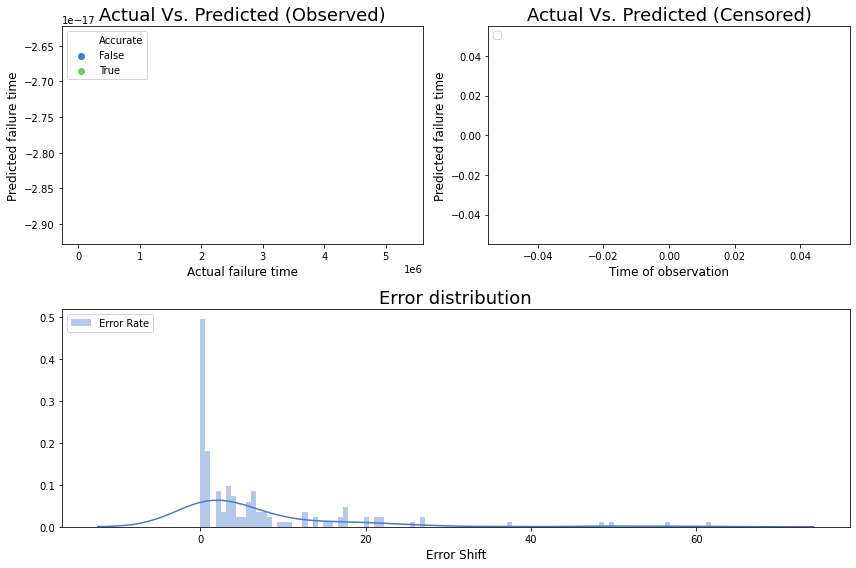

In [56]:
plot_predictions_insights(test_result_df);

14.931 %
8.443295953557465


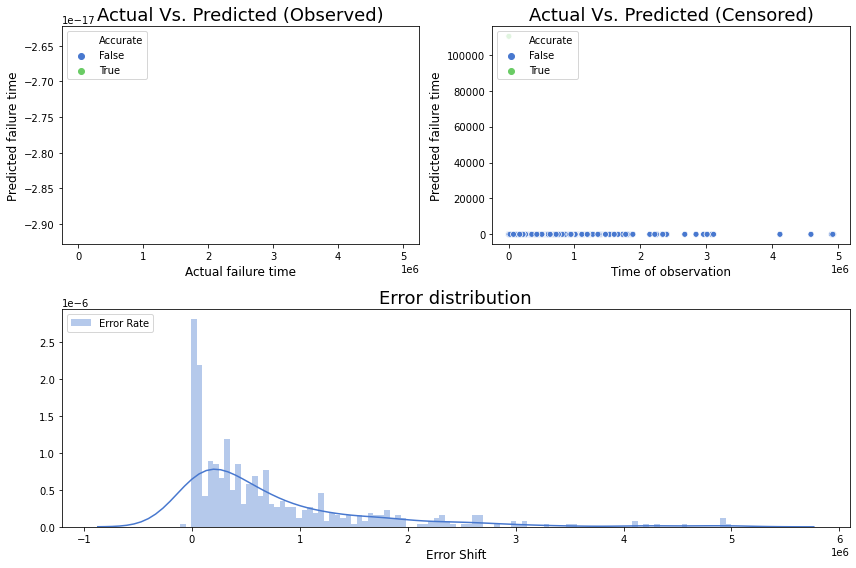

In [78]:
test_result_df, mae, accuracy = evaluating(X_train,y_train, model,resolution='s')
print(accuracy, "%")
print(mae)
plot_predictions_insights(test_result_df)

In [15]:
# plot_top_predictions(test_result_df,15,top_feature="T",ascending=False, U=1,accurate=True)

In [61]:
######################################################################################
censored   = False
cen_prc = None
res = "s"
key = "b"
maes_path = 'output_files/maes/'

if censored == False:
    filename = "observed_"+str(cen_prc)+"_"+res+".pkl"
    model_path = 'output_files/models/observed/'
else:
    filename = "censored_"+str(cen_prc)+"_"+res+".pkl"
    ## model_path stores the model weights and history training
    model_path = 'output_files/models/censored/'
######################################################################################
mae_list=[]
res_list=[]
print("dataset:",key)
for suffix in range_dict[key]:
    print("\tsuffix:",suffix)
    print("\t\tpreprocessing", end =" ...... ")
    dataset_preprocessed = preprocess(df_dict[key], 
                                      min_length = suffix,
                                      censored   = censored,  
                                      cen_prc    = cen_prc)
    print("done")
    print("\t\tsuffix splitting", end = " ... ")
    X_train, X_test, X_val, y_train, y_test, y_val = smart_split(dataset_preprocessed, 
                                                                 train_perc = 0.70,
                                                                 val_perc   = 0.3,
                                                                 suffix     = suffix,
                                                                 resolution = res,
                                                                 scaling    = True)
    print("done")
    print("\t\t\tTraining   shape:",X_train.shape, y_train.shape)
    print("\t\t\tValidation shape:",X_val.shape, y_val.shape)
    print("\t\t\tTesting    shape:",X_test.shape, y_test.shape)
    print("\t\tTraining", end =" ........... ")
    model = train(X_train, y_train, X_val, y_val, suffix, model_path)
    print("done")
    result_df, mae,accuracy = evaluating(X_test,y_test,model,resolution=res)
    print("\t\t\tMAE:",mae)
    print("\t\t\tAcc:",accuracy, "%")
    mae_list.append(mae)
    res_list.append(result_df)   
pickle.dump(res_list, open(model_path + "ResultDF_" + filename,"wb"))
pickle.dump(mae_list, open(maes_path + filename,"wb"))

dataset: b
	suffix: 2
		preprocessing ...... done
		suffix splitting ... Total above suffix: 6634
Total Observed: 6634
Total above suffix (observed): 6634
Training data Observed: 3251
Training data Censored: 0
Training data combined: 3251
done
			Training   shape: (3251, 2, 8) (3251, 2)
			Validation shape: (1392, 2, 8) (1392, 2)
			Testing    shape: (1991, 2, 8) (1991, 2)
		Training ........... done
			MAE: 13.981557101518844
			Acc: 17.981 %
	suffix: 4
		preprocessing ...... done
		suffix splitting ... Total above suffix: 5412
Total Observed: 5412
Total above suffix (observed): 5412
Training data Observed: 2652
Training data Censored: 0
Training data combined: 2652
done
			Training   shape: (2652, 4, 8) (2652, 2)
			Validation shape: (1136, 4, 8) (1136, 2)
			Testing    shape: (1624, 4, 8) (1624, 2)
		Training ........... done
			MAE: 11.605106014519109
			Acc: 18.658 %
	suffix: 6
		preprocessing ...... done
		suffix splitting ... Total above suffix: 4308
Total Observed: 4308
Total a

In [21]:
# case = 'censored_50_s.pkl'
# pickle.load(open(case, "rb"))
# pickle.dump(pickle.load(open(case, "rb"))["b"], open("baseline_practical.pkl", "wb"))

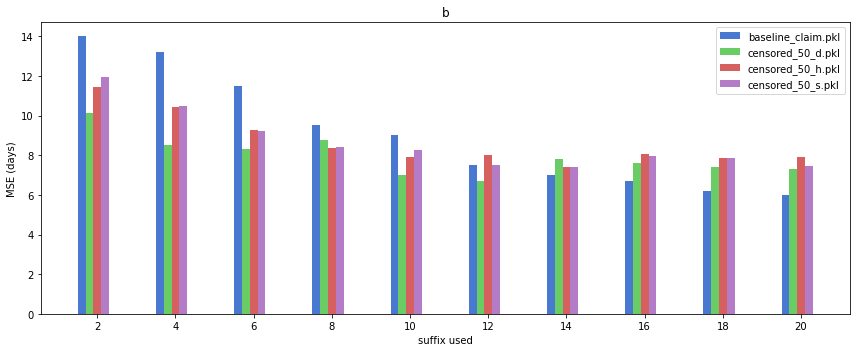

In [27]:
cases = ["baseline_claim.pkl", "observed_40_s.pkl", "censored_50_h.pkl", "censored_50_s.pkl"]

fig, ax = plt.subplots(1, 1, figsize=(12,5))

for i,dataset in enumerate(['b']):

    X = np.array(range_dict[dataset])
    steps = [-0.4, -0.2, 0, 0.2]
    for j,case in enumerate(cases):
        data = pickle.load(open(maes_path + case,"rb"));
        plt.bar(X+steps[j], data, width = 0.2, label=case);
    
    plt.xticks(range_dict[dataset])
    plt.legend();
    plt.xlabel("suffix used")
    plt.ylabel("MSE (days)")
    plt.title(dataset)
plt.tight_layout()
plt.show()

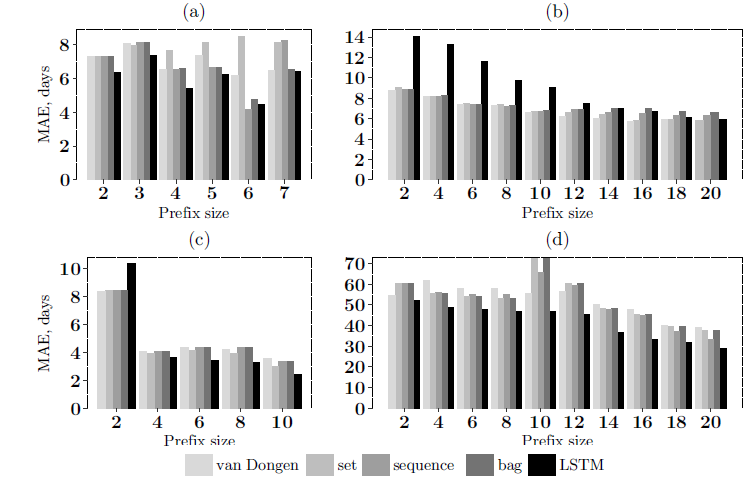

suffix =  2
0    169
Name: predicted_mode, dtype: int64


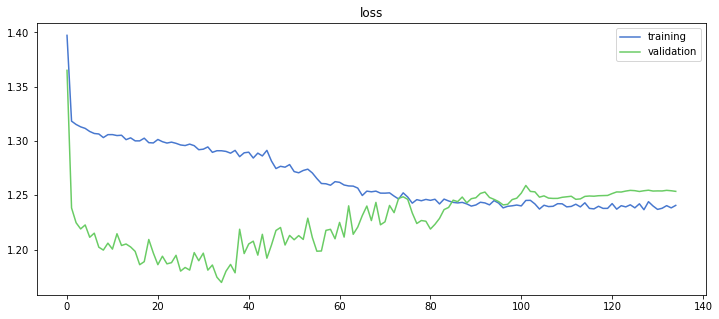

suffix =  4
0.000000e+00    1182
1.741215e+06       2
2.364516e+04       2
1.868519e+06       2
8.910431e+05       2
                ... 
1.741147e+06       1
2.520153e+04       1
4.115759e+05       1
7.065964e+05       1
4.255752e+05       1
Name: predicted_mode, Length: 998, dtype: int64


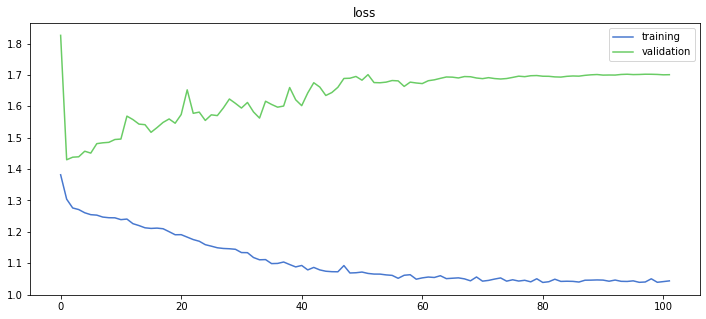

suffix =  6
0.000000e+00    611
1.073432e+06      1
6.191441e+05      1
6.452086e+05      1
9.425883e+05      1
               ... 
8.576436e+05      1
8.805231e+05      1
1.750781e+05      1
2.859706e+05      1
2.710367e+05      1
Name: predicted_mode, Length: 1176, dtype: int64


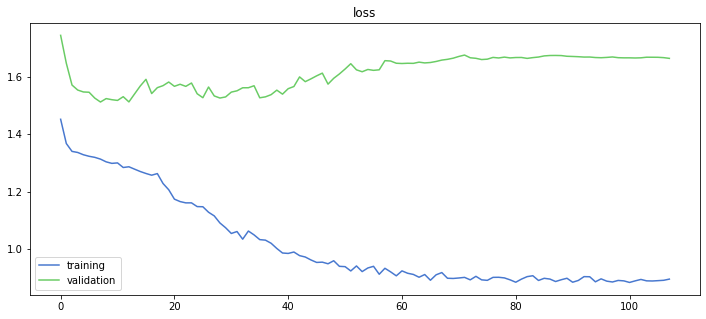

suffix =  8
0.000000         925
785752.803089      1
44348.823020       1
627945.053045      1
82253.877583       1
                ... 
162204.330407      1
239448.137450      1
679493.029762      1
121687.973684      1
330235.515064      1
Name: predicted_mode, Length: 498, dtype: int64


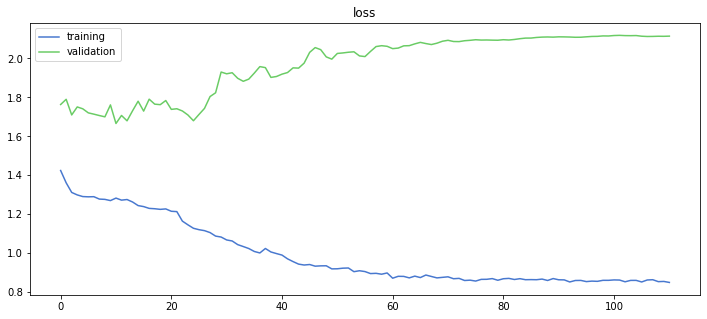

suffix =  10
0.000000         745
856324.693754      1
160319.873996      1
251398.437894      1
20179.496452       1
                ... 
598092.723099      1
384890.596426      1
114044.481878      1
230634.009559      1
189306.042088      1
Name: predicted_mode, Length: 363, dtype: int64


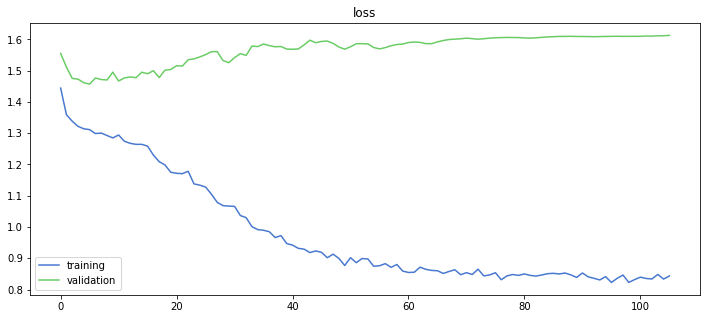

suffix =  12
0.000000         440
454062.033222      1
402509.613628      1
184840.193864      1
833001.261374      1
                ... 
332967.767150      1
345251.652739      1
283409.503159      1
58081.434991       1
320062.475252      1
Name: predicted_mode, Length: 398, dtype: int64


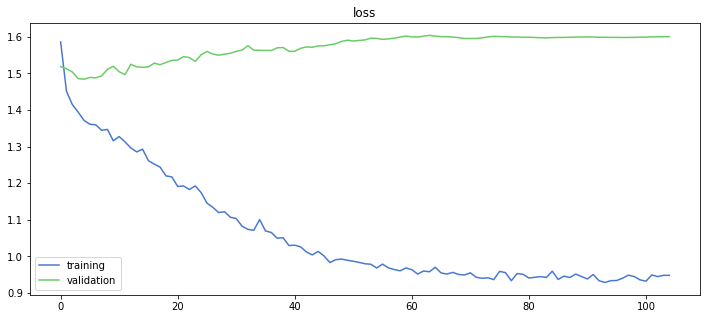

suffix =  14
0.000000e+00    425
1.146298e+06      1
7.284861e+05      1
2.272860e+04      1
1.019189e+06      1
               ... 
5.970553e+05      1
1.001580e+06      1
7.795295e+04      1
1.149717e+06      1
2.003721e+05      1
Name: predicted_mode, Length: 202, dtype: int64


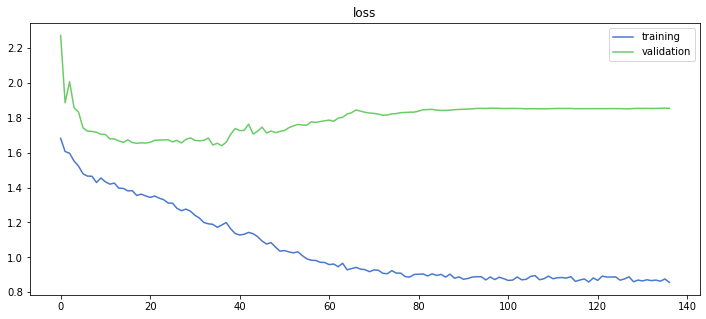

suffix =  16
0.000000e+00    250
1.861694e+04      1
8.478032e+05      1
1.222259e+03      1
1.122859e+06      1
               ... 
8.379701e+05      1
1.456961e+05      1
3.172219e+05      1
5.414739e+05      1
3.251906e+05      1
Name: predicted_mode, Length: 204, dtype: int64


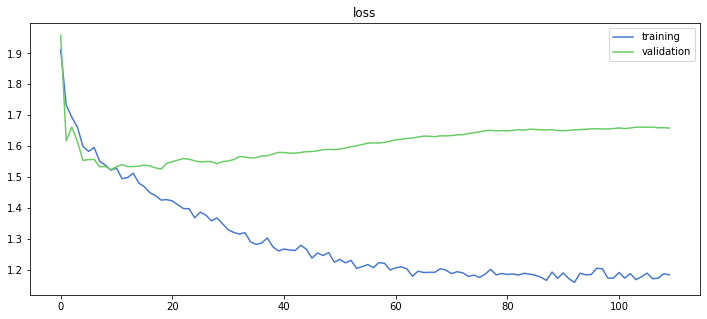

suffix =  18
0.000000         246
194438.850453      1
620067.631355      1
391827.725208      1
89908.593333       1
                ... 
44177.587447       1
190419.989236      1
26462.392961       1
386403.014423      1
22975.678320       1
Name: predicted_mode, Length: 71, dtype: int64


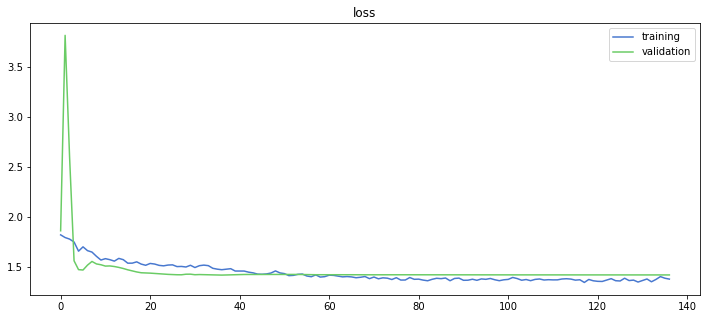

suffix =  20
0    231
Name: predicted_mode, dtype: int64


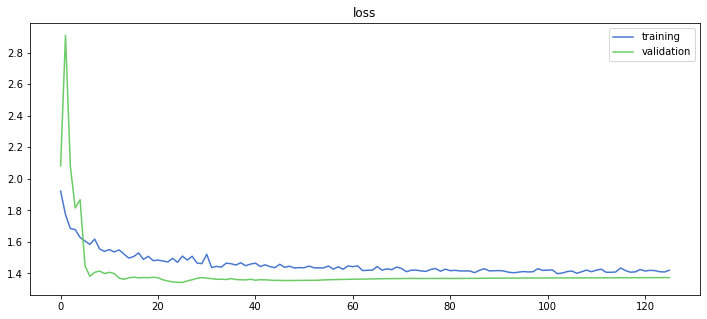

In [33]:
for i, suffix in enumerate(range_dict[dataset]):

    print("suffix = ", suffix)
    print(test_result_df["predicted_mode"].value_counts())
    history = pd.read_csv(path +'training_'+str(suffix)+'.log', sep=',', engine='python')
    test_result_df = pickle.load(open(path+"test_res_censored_50_s.pkl", "rb"))[i]
    plt.figure(figsize = (12,5));
    plt.plot(history['loss'], label='training');
    plt.plot(history['val_loss'],label='validation');
    plt.title('loss');
    plt.legend();
    plt.show();
    print("============================================================================")